# Manifesto map

> The magic of a word — Dada — which has brought journalists to the gates of a world unforeseen, is of no importance to us.

> To put out a manifesto you must want: ABC

> to fulminate against 1, 2, 3

> to fly into a rage and sharpen your wings to conquer and disseminate little abcs and big abcs, to
sign, shout, swear, to organize prose into a form of absolute and irrefutable evidence, to prove
your non plus ultra and maintain that novelty resembles life ...

>> Dada Manifesto, Tristan Tzara, 1918

## Overview
It is useful to map documents, for example, books and articles, to gain a greater understanding of the relationships between them, and help 
identify hidden connections between the documents.

This notebook maps texts based on simularities between the words that they contain.  The texts were featured in the 2015 film installation [Manifesto](https://en.wikipedia.org/wiki/Manifesto_\(2015_film\)) written, produced and directed by Julian Rosefeldt, in which Cate Blanchett reads out a series of manifestos.  The manifestos are grouped into a number of classifications, for example, Situationism, Futurism and Dadaism.  The aim of the work is to map out the different manifestos, and see how that mapping corresponds to the classifications given.

Three plots are produced:
 - the document simularity matrix showing the simularith between pairs of documents
 - a scatter plot, or map, of the documents after processing
 - a tree diagram showing how the documents are clustered together.

A key part of this process is **vectorisation** of a text string.  This means counting the words in a text string and turning these into a vector.  For example in the document 'the stupid dog jumped over the stupid fox' can be re-ordered as ['dog', 'fox, 'jumped', 'over', 'stupid', 'the'] and then represented as the feature vector  [1,1,1,1,2,2] where each number represents the number of times the word occurs, with the words being arranged in alphabetic order.  The set of all the words in each document is the **vocabulary**.  Each document will have a different feature vector, and similar documents will have similar feature vectors.  The **cosine similarity** expresses this similarity mathematically.

## Processing flow

### File preparation - manual processing
Documents mentioned in the [Manifesto](https://en.wikipedia.org/wiki/Manifesto_\(2015_film\)) film were scraped into a `.txt` file and saved in the `data` directory.  This step was only possible for documents available on the web as a text, PDF or other readable file.  Documents not found in these formats were not included in the corpus of documents used for subsequent processsing.  An index file [index.csv](data/index.csv) was also created and saved.  This file links the file name to the text's Title, Author, Year, Category and web page from which the document was sourced.

### Read in files and cleanse files
The files are read in and cleansed to remove non text strings and numbers.  This is done using the [re](https://docs.python.org/3/library/re.html) regular expressions module by replacing strings `'<.*?>'` or `'[^a-zA-Z\s]'`, with the empty string `''`, noting that `[ ]` signifiers a range of charactors, and `^` signifies inverting a string.  The line feeds are stripped out of the file, so that each file is transformed into a long text string, containing all the file's words and the spaces between words.

### Combine files
Next, the text strings for each file, are combined into a python list called `corpus`.

### Stemming and Vectorisation
There is an option to [**stemmed**](https://en.wikipedia.org/wiki/Stemming) the words in the corpus.  Stemming is "the process of reducing inflected (or sometimes derived) words to their word stem, base or root form—generally a written word form".  For example the stemming algorithm used reduces the words argue, argued, argues, arguing, argus to the stem argu. This simplifies subsequent analysis, by reducing the number of distinct words to be analysed.

Next the corpus is vectorised, meaning that a feature vector matrix is created, as described above.  The simplest approach to vectorise the corpus is to **count** each word.  A flaw with simply counting the words is that words like 'and', 'the' are prevalent in each document, and so each vector is fairly similar, and analysis is more challenging.  It is possible to use a **stop list** to remove common words from the analysis. Instead, there is an option to use a more advanced approach called [tf–idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) short for **term frequency–inverse document frequency**, as described in [Wikipedia](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

Here the term frequency $tf(t, d)$ is the relative frequency of a term t in a document d, where terms are the stemmed words and $f_{t,d}$ is the number of times that term t occurs in document d:
$${\displaystyle \mathrm {tf} (t,d)={\frac {f_{t,d}}{\sum _{t'\in d}{f_{t',d}}}}}$$ 

The inverse document frequency $idf(t,D)$ of a term $t$ in a corpus of documents $D$ is is a measure of how much information the term $t$ provides, i.e., how common or rare it is across all documents.  It is the logarithmically scaled inverse fraction of the documents that contain the word (obtained by dividing the total number of documents by the number of documents containing the word, and then taking the logarithm of that quotient).  
$${\displaystyle \mathrm {idf} (t,D)=\log {\frac {N}{|\{d:d\in D{\text{ and }}t\in d\}|}}}$$  

where $N$ is the total number of documents in the corpus $D$ and $d$ represents the individual documents, 

Then:
$${\displaystyle \mathrm {tfidf} (t,d,D)=\mathrm {tf} (t,d)\cdot \mathrm {idf} (t,D)}$$

So, for example, if a term appears in many documents, then the **inverse document frequency** is low, and the tf-idf is likely to be low too.  A term that is common but in a only a few number of documents is likely to have a high tf-idf.  

To reduce the number of features the parameter `MAX_DF` was set to 80%, meaning that common terms in more than 80% of the documents were ignored when building the vocabulary.  The parameter `MIN_DF` was set to 20%, meaning that rare words that occured in less than 20% of the documents were excluded.  This helps eliminates any incorrect words that may have arisen if the document was turned into text by optical charactor recognition.

There is an option to use either **counting** and **term frequency–inverse document frequency** as well as the option to use, or not use, stemming.

### Feature matrix processing and plotting.
A simularity matrix is produced from the feature matrix using a pairwise [**cosine similarity**](https://scikit-learn.org/1.5/modules/metrics.html#metrics) method.  This matrix holds the similarity between each pair of documents in the corpus and is calulated by finding the normalised dot product of the feature vector of each pair of documents.  Effectively, the vectors are projected onto the unit sphere, and their dot product is then the cosine of the angle between the points denoted by the vectors.

The result varies from 1, for documents that are identical, to 0, for documents that share no common words.  The simularity matrix is plotted and [saved](plot/Simularity_matrix.png).

### Scatter map processing and plotting
We need to plot the documents on a two dimensional map, yet the simularity matrix has as many dimensions as there are documents.  A mathematical technique called [Principal Component Analysis](https://scikit-learn.org/1.5/modules/decomposition.html#pca) (PCA) is used to find the main two components of the simularity matrix.  Then a scatter plot showing the manifesto map is plotted and [saved](plot/Manifesto_map.png)

### Ward cluster processing and Dendogram plotting
[Ward](https://en.wikipedia.org/wiki/Ward%27s_method) clustering is used group similar documents together, to produce a tree diagram, or Dendogram, which is plotted and [saved](plot/Dendogram.png).  

Ward clustering is an example of [Hierarchical clustering](https://scikit-learn.org/1.5/modules/clustering.html#hierarchical-clustering).  
The algorithm starts with each point representing a singleton cluster, and then in each step the number of clusters is reduced by one so that the increase in the sum of squared differences between each cluster centre is minimised.  


Import packages and modules needed.

In [28]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from text_functions import read_index, read_text_files
from text_functions import tokenize

from clustering_functions import calculate_simularity_matrix, pca_reduction

from plot_functions import plot_matrix, plot_dendogram, plot_scatter

import pprint

Set constants to control subsequent processing:

In [29]:
PATH_DATA = 'data/'         #path for data
PATH_PLOT = 'plot/'         #path for plots
INDEX_FILE = 'index.csv'    #location of index file 
ENCODING = 'utf-8-sig'      #Encoding of files
METHOD = 'Tfidf'            #'Tfidf' for Term Frequency - Inverse Document Frequency 
                            # or 'Count' for naive methods
MAX_DF = 0.8                #default 1.0.  When building the vocabulary ignore terms that have a 
                            #document frequency higher than the given threshold
MIN_DF = 0.2                #default 1.  When building the vocabulary ignore terms that have a document 
                            # frequency lower than the given threshold.
STEM = True                 #stem words when preprocessing the data
PCA_COMPONENTS = 2          #number of PCA components to keep (only two are plotted)
OFFSET = 0                  #Offset for annotations on scatter plot
ANNOTATE_PLOT = False       #Annotate scatter plot
VERBOSE = False             #Add more information?

Read in the next file and store as a dictionary `index_dict`.  Use this read the text files, and assemnle into a `corpus` list.

In [30]:
index_filename = PATH_DATA + INDEX_FILE
index_dict = read_index(index_filename, ENCODING)
if VERBOSE:
    pprint.pp(index_dict)
corpus = read_text_files(index_dict, ENCODING, PATH_DATA)

Define a vectoriser and use it to produce a feature matrix `X` based on the word frequencies in the documents.

In [31]:
if METHOD == 'Tfidf':
    if STEM:
        vectorizer = TfidfVectorizer(max_df=MAX_DF, min_df=MIN_DF, tokenizer=tokenize)
    else:
        vectorizer = TfidfVectorizer(max_df=MAX_DF, min_df=MIN_DF)
elif METHOD == 'count':
    if STEM:
        vectorizer = CountVectorizer(tokenizer=tokenize)
    else:
        vectorizer = CountVectorizer()
else:
    raise Exception('Unknown methods')

# Fit the vectorizer to the documents and transform the documents into a document-term matrix
X = vectorizer.fit_transform(corpus)

# Get the feature names
feature_names = vectorizer.get_feature_names_out()
print(f'There are {len(feature_names)} features')

c:\Users\DanielGoldsmith\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


There are 484 features


Calculate the simularity matrix from the features using the cosine similarity metric from SK Learn.

In [32]:
simularity_matrix = calculate_simularity_matrix(X)

Plot out the simularity matrix.  Lighter colours mean that the documents are more similar.

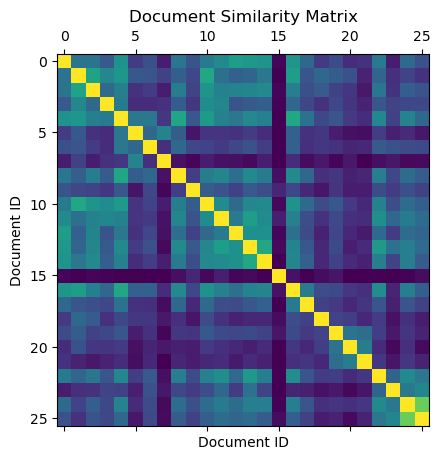

In [33]:
plot_matrix(simularity_matrix, PATH_PLOT)

Run principal component analysis to find the two principal components.

In [34]:
x, y = pca_reduction(simularity_matrix, PCA_COMPONENTS)

Plot out the two principle components of each manifesto.  This is a manifesto map, were more similar manifestos are closer together.

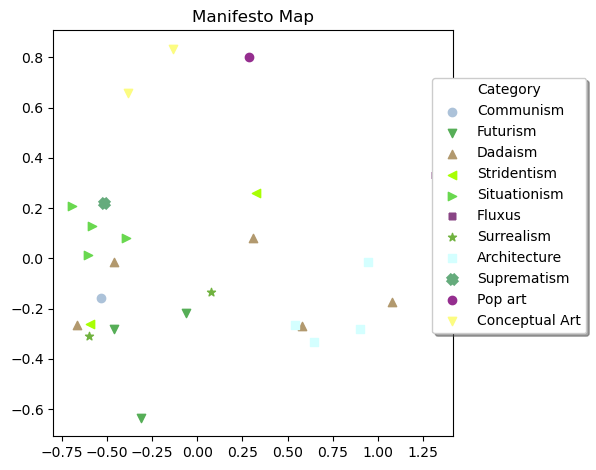

In [35]:
plot_scatter(index_dict, x, y, OFFSET, PATH_PLOT, annotate=ANNOTATE_PLOT)

Use Ward clustering to find out which manifestos are most similar, and plot these out as a Dendogram.

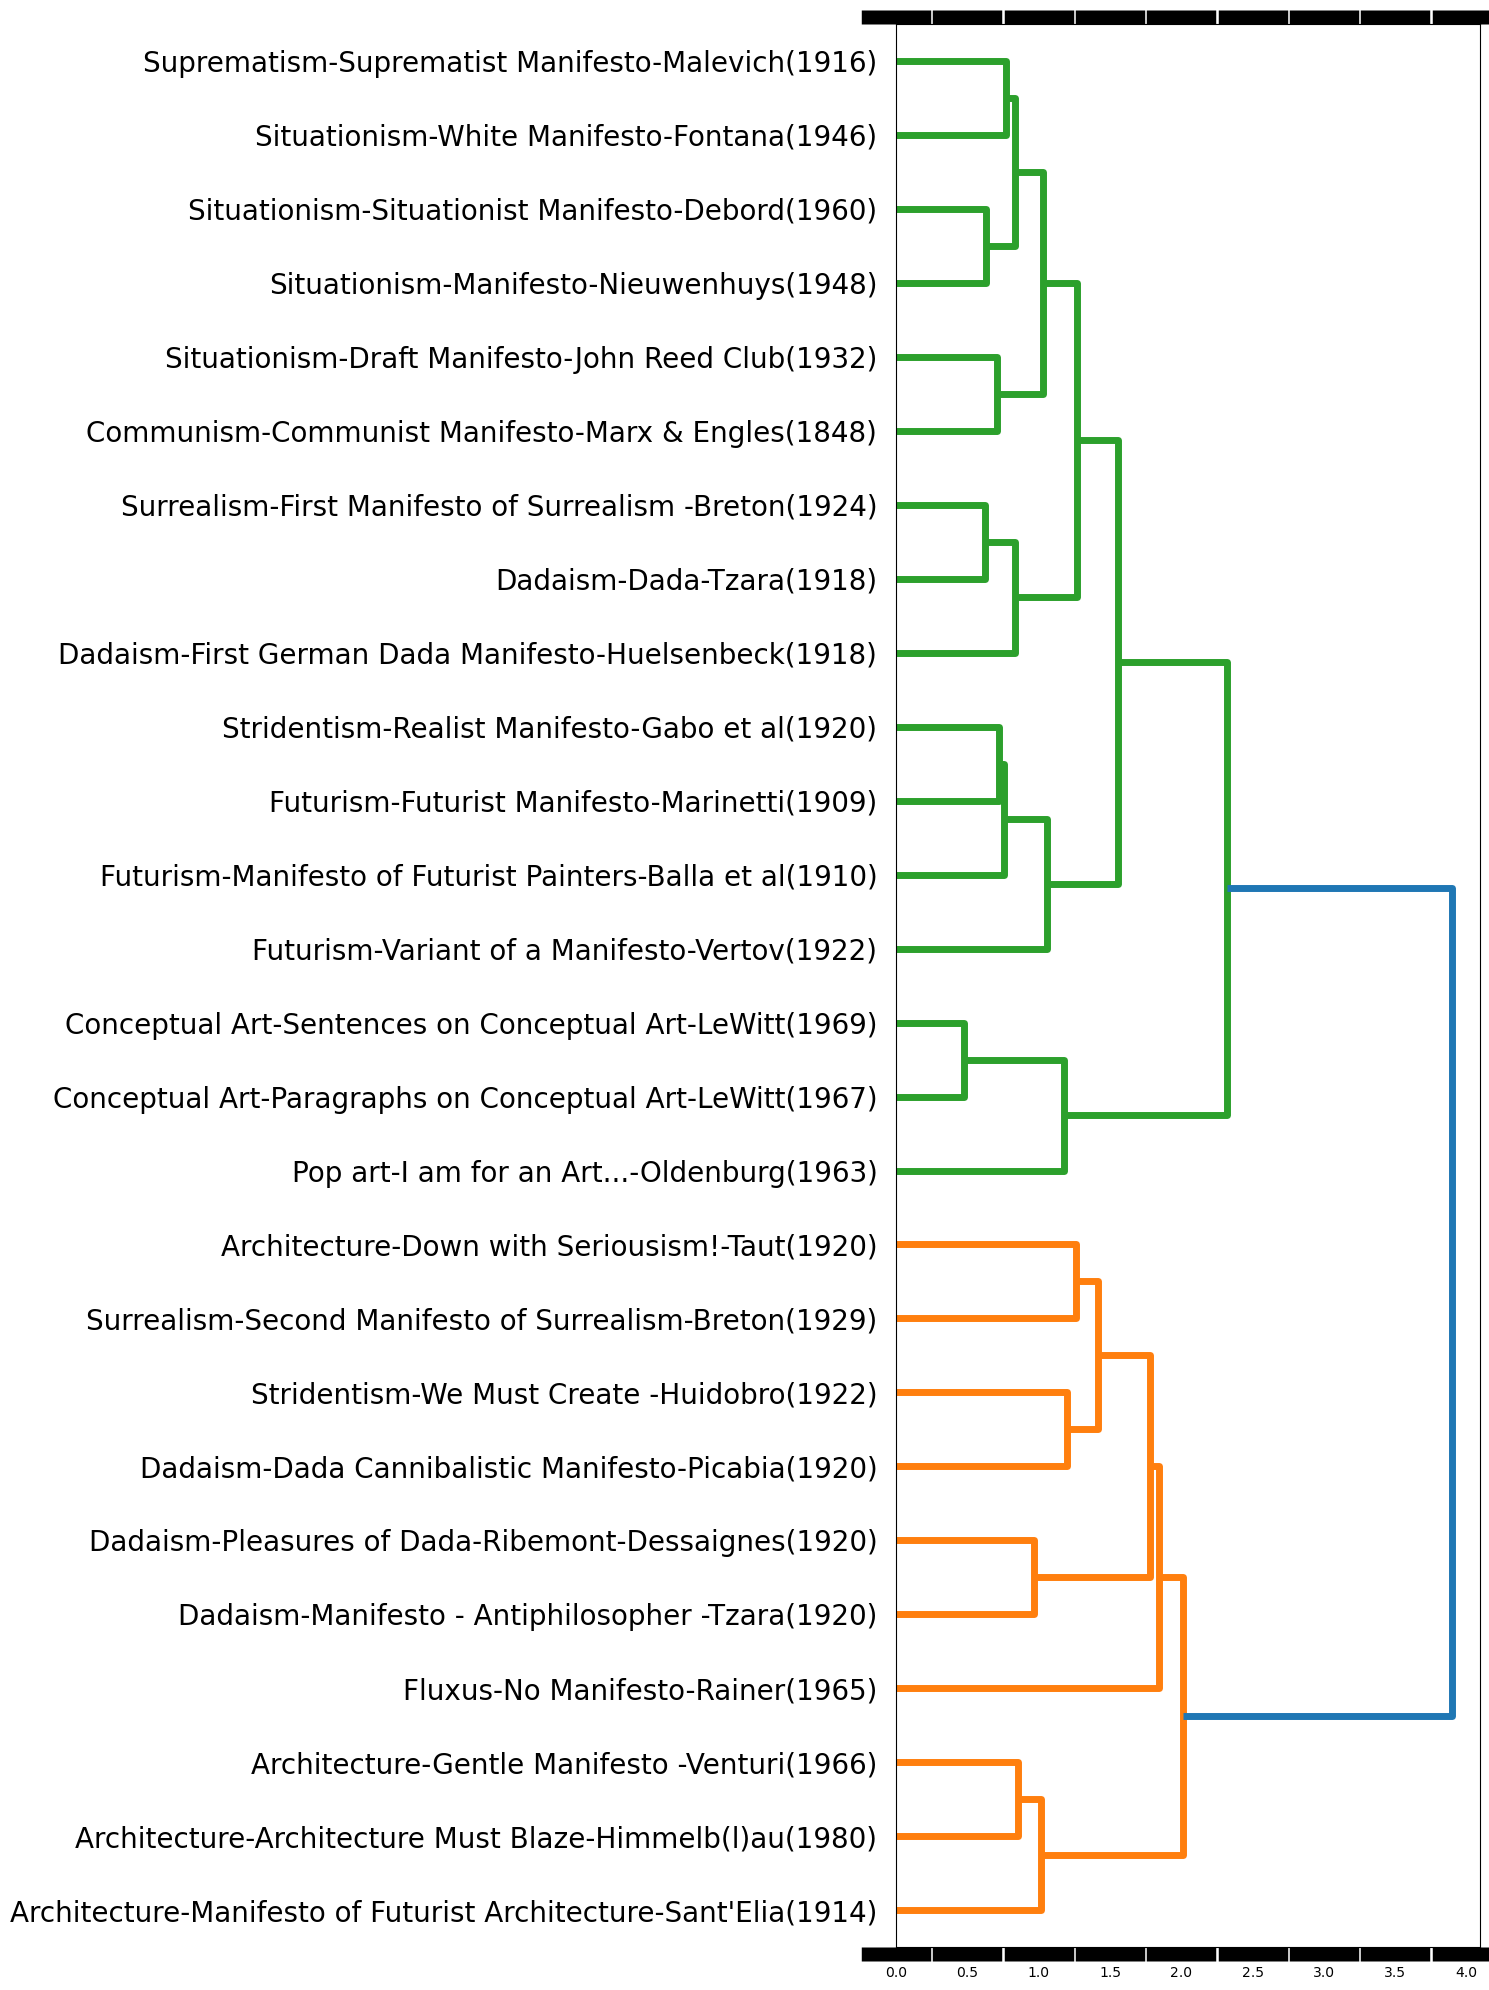

In [36]:
plot_dendogram(simularity_matrix, index_dict, PATH_PLOT)

## Results and discussions

Despite the simiplicity of the approach, the clustering is reasonably successful.  The four "Situationalist" manifestos are plotted close together, and are close on the Dendogram.  There are also clear clusters for the "Architecture" and "Conceptual Art" manifestos.  On the Dendogram three of the "Dada" texts are close togehter, and another two are close, even though this is less clear on the plot.  The two "Surrealism" manifesto are not clustered together, either on the plot, or the Dendogram, and nor are the two "Stridentism" manifestos.

The techniques used are not particularly modern.  [td-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) was first suggested in 1972, [Ward](https://en.wikipedia.org/wiki/Ward%27s_method) in 1963 and [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) was invented in 1901.  It is possible more modern techniques described by [Malteus](https://github.com/malteos/awesome-document-similarity) such as [BERT](https://arxiv.org/abs/1810.04805) or [Generative Pre Training](https://www.techbooky.com/wp-content/uploads/2019/02/Better-Language-Models-and-Their-Implications.pdf) may yield better results.  However, these are currently beyond the scope of this work.

The analysis of the 26 manifestos takes place in seconds.

## Conclusion

It is relatively straightforward to obtain the similarity between texts using techniques readily available in SciKit Learn and SciPi such as td-if vectorisation, PCA reduction and Ward clustering.  A map of the texts produced broadly follows classification assigned by human experts.  